In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep


Using TensorFlow backend.


In [2]:
#Load APADB Data and filter on targeted genes

#genes = ['RUNX1', 'CEBPA', 'GATA2', 'ANKRD26', 'DDX41', 'ETV6', 'PTEN', 'BRCA1', 'BRCA2', 'TP53', 'APC', 'ATM', 'PALB2', 'MSH2', 'MLH1', 'MSH6', 'PMS2', 'MUTYH']

polyadb_df = pd.read_csv('../../../data/native_data/polyadb/processed_data/polyadb_processed.csv', sep=',')

#polyadb_df = polyadb_df.loc[polyadb_df['gene'].isin(genes)].reset_index(drop=True).copy()
polyadb_df = polyadb_df.loc[~polyadb_df['gene'].isna()].reset_index(drop=True).copy()
polyadb_df = polyadb_df.loc[polyadb_df['gene'] != 'na'].reset_index(drop=True).copy()

print('len(polyadb_df) = ' + str(len(polyadb_df)))


len(polyadb_df) = 190117


In [3]:
polyadb_df_minus = polyadb_df.query("strand == '-'").copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df.query("strand == '+'").copy().reset_index(drop=True)

polyadb_df_minus = polyadb_df_minus.sort_values(by='pas_pos', ascending=False).copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df_plus.sort_values(by='pas_pos', ascending=True).copy().reset_index(drop=True)

new_gene_id_list_plus = []
sitenum_list_plus = []
gene_id_dict = {}
for _, row in polyadb_df_plus.iterrows() :

    gene = str(row['gene'])

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_plus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_plus.append(gene_id_dict[gene])

polyadb_df_plus['gene_id'] = new_gene_id_list_plus
polyadb_df_plus['sitenum'] = sitenum_list_plus

new_gene_id_list_minus = []
sitenum_list_minus = []
gene_id_dict = {}
for _, row in polyadb_df_minus.iterrows() :

    gene = str(row['gene'])

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_minus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_minus.append(gene_id_dict[gene])

polyadb_df_minus['gene_id'] = new_gene_id_list_minus
polyadb_df_minus['sitenum'] = sitenum_list_minus

polyadb_df = pd.concat([polyadb_df_plus, polyadb_df_minus])

polyadb_df = polyadb_df.sort_values(by=['gene', 'sitenum'], ascending=True).reset_index(drop=True).copy()

In [4]:
polyadb_df.head()

,gene,gene_id,sitenum,num_sites,pas,seq,seq_ext,wide_seq,wide_seq_ext,rpm,total_rpm,ratio,pas_pos,cut_mode,chrom,strand,site_type
0,A1BG,A1BG.1,1,11,0,TTCTGCTAGGCTGGGCTAGTATCTTCCATGGCAAGATACTCAAACT...,TAGGGAATATAACTTTTAAAATGCGAAAGTATATTATACATATTGC...,AGTTTGGCTAGCATTTCAAAATGGATAGGGAATATAACTTTTAAAA...,GCTTTCAAAATTCCTGATTAGCTTACAATTAATTGCAAATAACTTC...,1.564234,24.390222,0.064134,58859852,58859830,chr19,-,Intron
1,A1BG,A1BG.2,2,11,-1,AGGTGCCGCTACCGCTCCTGGGTGCCCCACACCTTCGAATCGGAGC...,CGGCGAACCTCGAGCTGATCTTCGTGGGGCCCCAGCACGCCGGCAA...,AAGACGGTCCGCACCCCCGGGGCCGCGGCGAACCTCGAGCTGATCT...,TCCCCGACGTCACCTTCGAGCTGCTGCGCGAGGGCGAGACGAAGGC...,1.740036,24.390222,0.071342,58858744,58858719,chr19,-,Internal_exon
2,A1BG,A1BG.3,3,11,0,CCGGGGTCTCTGGGGGGCTGGAGAAGCCTCCCTCATTCCTCCCAGG...,AGTGCCGGGGATTCTGGACTGGCTCCCTCCCCTCCTGTTGCAGCAC...,CCAGGGTGCTGTTGGTGTCCTCAGAAGTGCCGGGGATTCTGGACTG...,CACCATTTCTCTTTTCTCCCGTTGTCTAGAAAGCTGATGCAGCCGC...,11.529986,24.390222,0.472730,58858249,58858220,chr19,-,3_most_exon
3,A1BG,A1BG.4,4,11,4,GAAGATGCGTATCAGTATTATCAACCAATAGTTGATGAATTGTGTT...,ACCACTGCCGAGTTTCTGCCTGGAGCAGGGCCTCAAGGCCCTGGCA...,CCATCTGACATCTGATGCCTTCCCAACCACTGCCGAGTTTCTGCCT...,GATTCCTCTGTGTTCTTTCCCATTATCCCTCAGCTCTGAGTCCTCT...,1.386686,24.390222,0.056854,58857215,58857210,chr19,-,3_most_exon
4,A1BG,A1BG.5,5,11,4,AACGAATTTGCTAGTGATCTGGTTTACTGCCTTAGTAATATCTAGT...,GAAGATGCGTATCAGTATTATCAACCAATAGTTGATGAATTGTGTT...,CAGGGCCTCAAGGCCCTGGCACACAGAAGATGCGTATCAGTATTAT...,CCATCTGACATCTGATGCCTTCCCAACCACTGCCGAGTTTCTGCCT...,1.174863,24.390222,0.048169,58857165,58857142,chr19,-,3_most_exon


In [5]:

polyadb_df['start'] = polyadb_df['pas_pos'] - 150
polyadb_df['end'] = polyadb_df['pas_pos'] + 150

polyadb_bed = polyadb_df[['chrom', 'start', 'end', 'gene', 'gene_id', 'strand']].copy().reset_index(drop=True)

polyadb_bed.head()

polyadb_bed.to_csv("polyadb_coordinates.bed", sep='\t', header=False, index=False)


In [6]:
#Tissue types to compile data for

tissue_types = [
    'Adipose_Subcutaneous',
    'Adipose_Visceral_Omentum',
    'Adrenal_Gland',
    'Artery_Aorta',
    'Artery_Coronary',
    'Artery_Tibial',
    'Brain_Amygdala',
    'Brain_Anterior_cingulate_cortex_BA24',
    'Brain_Caudate_basal_ganglia',
    'Brain_Cerebellar_Hemisphere',
    'Brain_Cerebellum',
    'Brain_Cortex',
    'Brain_Frontal_Cortex_BA9',
    'Brain_Hippocampus',
    'Brain_Hypothalamus',
    'Brain_Nucleus_accumbens_basal_ganglia',
    'Brain_Putamen_basal_ganglia',
    'Brain_Spinal_cord_cervical_c-1',
    'Brain_Substantia_nigra',
    'Breast_Mammary_Tissue',
    'Cells_EBV-transformed_lymphocytes',
    'Cells_Cultured_fibroblasts',
    'Colon_Sigmoid',
    'Colon_Transverse',
    'Esophagus_Gastroesophageal_Junction',
    'Esophagus_Mucosa',
    'Esophagus_Muscularis',
    'Heart_Atrial_Appendage',
    'Heart_Left_Ventricle',
    'Kidney_Cortex',
    'Liver',
    'Lung',
    'Minor_Salivary_Gland',
    'Muscle_Skeletal',
    'Nerve_Tibial',
    'Ovary',
    'Pancreas',
    'Pituitary',
    'Prostate',
    'Skin_Not_Sun_Exposed_Suprapubic',
    'Skin_Sun_Exposed_Lower_leg',
    'Small_Intestine_Terminal_Ileum',
    'Spleen',
    'Stomach',
    'Testis',
    'Thyroid',
    'Uterus',
    'Vagina',
    'Whole_Blood'
]


In [7]:

version_suffix = '_v8_w_effect_sizes'


In [ ]:

merged_df_intron = pd.read_csv("../../../../aparent-resnet/analysis/predictions/apa_gtex_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_v8_intron_eqtl_nonlead_predictions_pred_df.csv", sep='\t')
merged_df_intron = merged_df_intron.query("eqtl_effect_size > -10000. and eqtl_p_val < 1e-5")

merged_df_utr3 = pd.read_csv("../../../../aparent-resnet/analysis/predictions/apa_gtex_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_v8_utr3_eqtl_nonlead_predictions_pred_df.csv", sep='\t')
merged_df_utr3 = merged_df_utr3.query("eqtl_effect_size > -10000. and eqtl_p_val < 1e-5")


In [9]:

first_utr3_pas = polyadb_df.query("site_type == '3_most_exon'").sort_values(by='sitenum', ascending=True).groupby(['gene']).agg({
    'sitenum' : 'first',
    'pas_pos' : 'first'
})

merged_df_intron = merged_df_intron.join(first_utr3_pas, on='gene', how='inner', rsuffix='_first_utr3')
merged_df_utr3 = merged_df_utr3.join(first_utr3_pas, on='gene', how='inner', rsuffix='_first_utr3')

merged_df_utr3 = merged_df_utr3.query("sitenum > sitenum_first_utr3").copy()


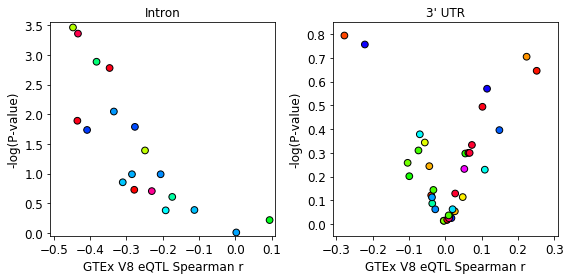

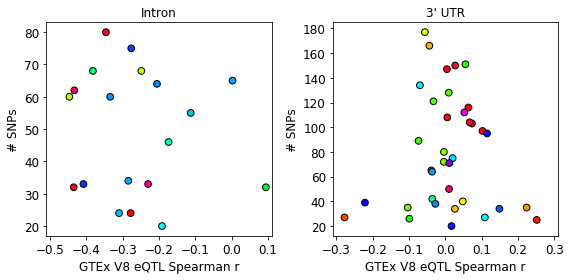

In [16]:
from scipy.stats import spearmanr

min_n = 20

def _compute_correlation_per_tissue(df) :
    
    unique_tissues = sorted(df['tissue_type'].unique().tolist())
    
    kept_tissue_types = []
    kept_spearman_rs = []
    kept_spearman_ps = []
    kept_ns = []

    for tissue_type in unique_tissues :

        sel_df = df.query("tissue_type == '" + tissue_type +"'").copy()

        sel_df = sel_df.query("ratio < 0.01").copy().reset_index(drop=True)

        if len(sel_df) < min_n :
            continue

        r_val, p_val = spearmanr(sel_df['delta_isoform_logodds'], sel_df['eqtl_effect_size'])

        kept_tissue_types.append(tissue_type)
        kept_spearman_rs.append(r_val)
        kept_spearman_ps.append(p_val)
        kept_ns.append(len(sel_df))
    
    return kept_tissue_types, kept_spearman_rs, kept_spearman_ps, kept_ns

kept_tissue_types_intron, kept_spearman_rs_intron, kept_spearman_ps_intron, kept_ns_intron = _compute_correlation_per_tissue(merged_df_intron)
kept_tissue_types_utr3, kept_spearman_rs_utr3, kept_spearman_ps_utr3, kept_ns_utr3 = _compute_correlation_per_tissue(merged_df_utr3)

cs_intron = np.random.uniform(low=0., high=1., size=(len(kept_spearman_rs_intron),))
cs_utr3 = np.random.uniform(low=0., high=1., size=(len(kept_spearman_rs_utr3),))

f, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].scatter(np.array(kept_spearman_rs_intron), -np.log(np.array(kept_spearman_ps_intron)) / np.log(10.), s=45, edgecolor='black', linewidth=1, cmap='hsv', c=cs_intron)
ax[1].scatter(np.array(kept_spearman_rs_utr3), -np.log(np.array(kept_spearman_ps_utr3)) / np.log(10.), s=45, edgecolor='black', linewidth=1, cmap='hsv', c=cs_utr3)

plt.sca(ax[0])

plt.title("Intron")

plt.xlim(-0.51, 0.11)
plt.ylim(-0.05, 3.55)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("GTEx V8 eQTL Spearman r", fontsize=12)
plt.ylabel("-log(P-value)", fontsize=12)

plt.sca(ax[1])

plt.title("3' UTR")

plt.xlim(-0.31, 0.31)
plt.ylim(-0.05, 0.85)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("GTEx V8 eQTL Spearman r", fontsize=12)
plt.ylabel("-log(P-value)", fontsize=12)

plt.tight_layout()

plt.show()

f, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].scatter(np.array(kept_spearman_rs_intron), np.array(kept_ns_intron), s=45, edgecolor='black', linewidth=1, cmap='hsv', c=cs_intron)
ax[1].scatter(np.array(kept_spearman_rs_utr3), np.array(kept_ns_utr3), s=45, edgecolor='black', linewidth=1, cmap='hsv', c=cs_utr3)

plt.sca(ax[0])

plt.title("Intron")

plt.xlim(-0.51, 0.11)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("GTEx V8 eQTL Spearman r", fontsize=12)
plt.ylabel("# SNPs", fontsize=12)

plt.sca(ax[1])

plt.title("3' UTR")

plt.xlim(-0.31, 0.31)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("GTEx V8 eQTL Spearman r", fontsize=12)
plt.ylabel("# SNPs", fontsize=12)

plt.tight_layout()

plt.show()


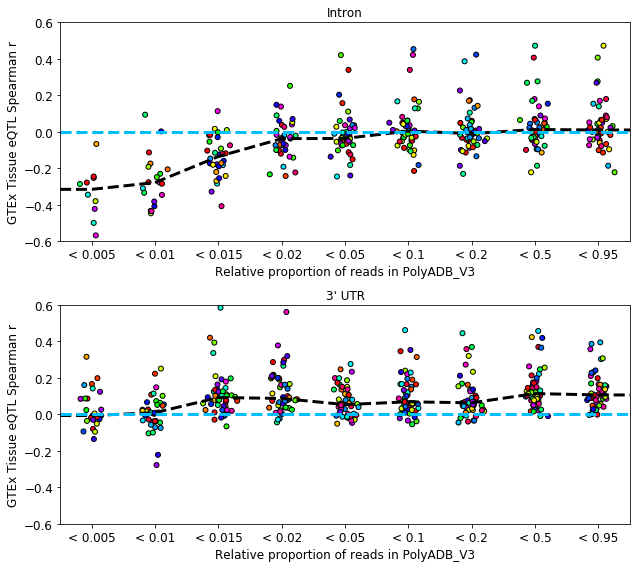

In [27]:
from scipy.stats import spearmanr

ratios = [0.005, 0.01, 0.015, 0.02, 0.05, 0.1, 0.2, 0.5, 0.95]

min_n = 20

def _calculate_correlation_per_ratio_cutoff(df) :
    
    kept_tissue_types = []
    kept_spearman_rs = []
    kept_spearman_ps = []
    kept_ns = []
    
    unique_tissues = sorted(df['tissue_type'].unique().tolist())

    for ratio in ratios :

        kept_tissue_types_curr = []
        kept_spearman_rs_curr = []
        kept_spearman_ps_curr = []
        kept_ns_curr = []

        for tissue_type in unique_tissues :

            sel_df = df.query("tissue_type == '" + tissue_type +"'").copy()

            sel_df = sel_df.query("ratio < " + str(ratio)).copy().reset_index(drop=True)

            if len(sel_df) < min_n :
                continue

            r_val, p_val = spearmanr(sel_df['delta_isoform_logodds'], sel_df['eqtl_effect_size'])

            kept_tissue_types_curr.append(tissue_type)
            kept_spearman_rs_curr.append(r_val)
            kept_spearman_ps_curr.append(p_val)
            kept_ns_curr.append(len(sel_df))

        kept_tissue_types.append(np.array(kept_tissue_types_curr))
        kept_spearman_rs.append(np.array(kept_spearman_rs_curr))
        kept_spearman_ps.append(np.array(kept_spearman_ps_curr))
        kept_ns.append(np.array(kept_ns_curr))
    
    return kept_tissue_types, kept_spearman_rs, kept_spearman_ps, kept_ns

kept_tissue_types_intron, kept_spearman_rs_intron, kept_spearman_ps_intron, kept_ns_intron = _calculate_correlation_per_ratio_cutoff(merged_df_intron)
kept_tissue_types_utr3, kept_spearman_rs_utr3, kept_spearman_ps_utr3, kept_ns_utr3 = _calculate_correlation_per_ratio_cutoff(merged_df_utr3)

f, ax = plt.subplots(2, 1, figsize=(9, 8))

r_medians_intron = []
r_medians_utr3 = []

for i in range(len(ratios)) :
    
    ratio = ratios[i]
    
    xs_intron = np.ones(kept_spearman_rs_intron[i].shape[0]) * i + np.random.normal(loc=0., scale=0.1, size=(kept_spearman_rs_intron[i].shape[0],)) 
    cs_intron = np.random.uniform(low=0., high=1., size=(kept_spearman_rs_intron[i].shape[0],))
    
    ax[0].scatter(xs_intron, kept_spearman_rs_intron[i], s=25, edgecolor='black', linewidth=1, cmap='hsv', c=cs_intron)
    
    r_medians_intron.append(np.median(kept_spearman_rs_intron[i]))
    
    xs_utr3 = np.ones(kept_spearman_rs_utr3[i].shape[0]) * i + np.random.normal(loc=0., scale=0.1, size=(kept_spearman_rs_utr3[i].shape[0],)) 
    cs_utr3 = np.random.uniform(low=0., high=1., size=(kept_spearman_rs_utr3[i].shape[0],))
    
    ax[1].scatter(xs_utr3, kept_spearman_rs_utr3[i], s=25, edgecolor='black', linewidth=1, cmap='hsv', c=cs_utr3)
    
    r_medians_utr3.append(np.median(kept_spearman_rs_utr3[i]))

ax[0].plot([-0.5] + np.arange(len(ratios)).tolist() + [len(ratios) - 0.5], [r_medians_intron[0]] + r_medians_intron + [r_medians_intron[-1]], linewidth=3, linestyle="--", color='black')
ax[1].plot([-0.5] + np.arange(len(ratios)).tolist() + [len(ratios) - 0.5], [r_medians_utr3[0]] + r_medians_utr3 + [r_medians_utr3[-1]], linewidth=3, linestyle="--", color='black')

ax[0].axhline(y=0.0, linewidth=3, linestyle='--', color='deepskyblue')
ax[1].axhline(y=0.0, linewidth=3, linestyle='--', color='deepskyblue')

plt.sca(ax[0])

plt.xticks(np.arange(len(ratios)), ["< " + str(ratio) for ratio in ratios], fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(-0.5, len(ratios) - 0.5)
plt.ylim(-0.6, 0.6)

plt.xlabel("Relative proportion of reads in PolyADB_V3", fontsize=12)
plt.ylabel("GTEx Tissue eQTL Spearman r", fontsize=12)
plt.title("Intron", fontsize=12)

plt.sca(ax[1])

plt.xticks(np.arange(len(ratios)), ["< " + str(ratio) for ratio in ratios], fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(-0.5, len(ratios) - 0.5)
plt.ylim(-0.6, 0.6)

plt.xlabel("Relative proportion of reads in PolyADB_V3", fontsize=12)
plt.ylabel("GTEx Tissue eQTL Spearman r", fontsize=12)
plt.title("3' UTR", fontsize=12)

plt.tight_layout()

plt.savefig("gtex_v8_intron_eqtl_spearman_r_by_ratio_cutoff.png", transparent=True, dpi=300)
plt.savefig("gtex_v8_intron_eqtl_spearman_r_by_ratio_cutoff.eps")

plt.show()


In [22]:
from scipy.stats import spearmanr

ratios = [0.005, 0.01, 0.015, 0.02, 0.05, 0.1, 0.2, 0.5, 0.95]

min_n = 20

n_bootstraps = 10000

low_q = 0.025
high_q = 0.975

def _compute_correlation_per_ratio_cutoff_bootstrap(df) :

    kept_tissue_types = []
    kept_spearman_rs = []
    kept_spearman_ps = []
    kept_ns = []

    kept_spearman_r_lows = []
    kept_spearman_r_highs = []

    unique_tissues = sorted(df['tissue_type'].unique().tolist())

    for ratio in ratios :

        print("Processing ratio cutoff = " + str(ratio))

        kept_tissue_types_curr = []
        kept_spearman_rs_curr = []
        kept_spearman_ps_curr = []
        kept_ns_curr = []

        kept_spearman_r_lows_curr = []
        kept_spearman_r_highs_curr = []

        for tissue_type in unique_tissues :

            sel_df = df.query("tissue_type == '" + tissue_type +"'").copy()

            sel_df = sel_df.query("ratio < " + str(ratio)).copy().reset_index(drop=True)

            if len(sel_df) < min_n :
                continue

            r_val, p_val = spearmanr(sel_df['delta_isoform_logodds'], sel_df['eqtl_effect_size'])

            kept_tissue_types_curr.append(tissue_type)
            kept_spearman_rs_curr.append(r_val)
            kept_spearman_ps_curr.append(p_val)
            kept_ns_curr.append(len(sel_df))

            data_index = np.arange(len(sel_df))

            if n_bootstraps > 0 :
                kept_spearman_rs_bootstrap = []
                for bootstrap_i in range(n_bootstraps) :
                    bootstrap_index = np.random.choice(data_index, size=(data_index.shape[0]), replace=True)

                    kept_spearman_rs_bootstrap.append(
                        spearmanr(sel_df['delta_isoform_logodds'].values[bootstrap_index], sel_df['eqtl_effect_size'].values[bootstrap_index])[0]
                    )

                kept_spearman_r_lows_curr.append(np.quantile(np.array(kept_spearman_rs_bootstrap), q=low_q))
                kept_spearman_r_highs_curr.append(np.quantile(np.array(kept_spearman_rs_bootstrap), q=high_q))

        kept_tissue_types.append(np.array(kept_tissue_types_curr))
        kept_spearman_rs.append(np.array(kept_spearman_rs_curr))
        kept_spearman_ps.append(np.array(kept_spearman_ps_curr))
        kept_ns.append(np.array(kept_ns_curr))

        kept_spearman_r_lows.append(np.array(kept_spearman_r_lows_curr))
        kept_spearman_r_highs.append(np.array(kept_spearman_r_highs_curr))
    
    return kept_tissue_types, kept_spearman_rs, kept_spearman_ps, kept_ns, kept_spearman_r_lows, kept_spearman_r_highs

kept_tissue_types_intron, kept_spearman_rs_intron, kept_spearman_ps_intron, kept_ns_intron, kept_spearman_r_lows_intron, kept_spearman_r_highs_intron = _compute_correlation_per_ratio_cutoff_bootstrap(merged_df_intron)
kept_tissue_types_utr3, kept_spearman_rs_utr3, kept_spearman_ps_utr3, kept_ns_utr3, kept_spearman_r_lows_utr3, kept_spearman_r_highs_utr3 = _compute_correlation_per_ratio_cutoff_bootstrap(merged_df_utr3)


Processing ratio cutoff = 0.005
Processing ratio cutoff = 0.01
Processing ratio cutoff = 0.015
Processing ratio cutoff = 0.02
Processing ratio cutoff = 0.05
Processing ratio cutoff = 0.1
Processing ratio cutoff = 0.2
Processing ratio cutoff = 0.5
Processing ratio cutoff = 0.95
Processing ratio cutoff = 0.005
Processing ratio cutoff = 0.01
Processing ratio cutoff = 0.015
Processing ratio cutoff = 0.02
Processing ratio cutoff = 0.05
Processing ratio cutoff = 0.1
Processing ratio cutoff = 0.2
Processing ratio cutoff = 0.5
Processing ratio cutoff = 0.95


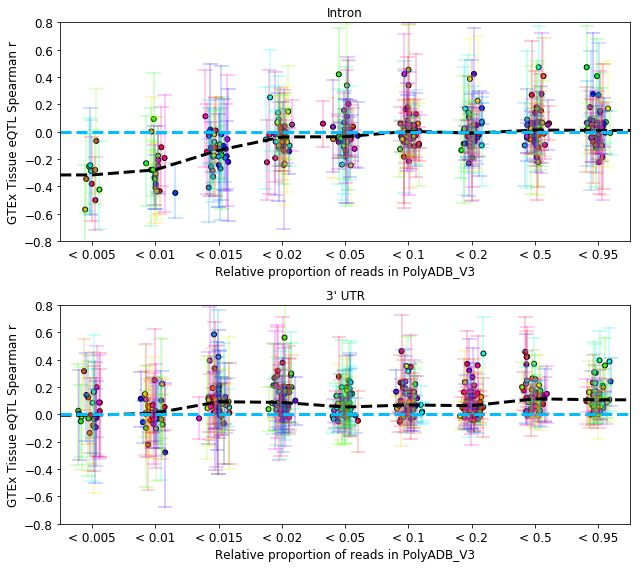

In [26]:

f, ax = plt.subplots(2, 1, figsize=(9, 8))

r_medians_intron = []
r_medians_utr3 = []

for i in range(len(ratios)) :
    
    ratio = ratios[i]
    
    xs_intron = np.ones(kept_spearman_rs_intron[i].shape[0]) * i + np.random.normal(loc=0., scale=0.1, size=(kept_spearman_rs_intron[i].shape[0],)) 
    cs_intron = np.random.uniform(low=0., high=1., size=(kept_spearman_rs_intron[i].shape[0],))
    
    ax[0].scatter(xs_intron, kept_spearman_rs_intron[i], s=25, edgecolor='black', linewidth=1, cmap='hsv', c=cs_intron)
    
    if n_bootstraps > 0 :
        for j in range(kept_spearman_rs_intron[i].shape[0]) :
            ax[0].plot([xs_intron[j], xs_intron[j]], [kept_spearman_r_lows_intron[i][j], kept_spearman_r_highs_intron[i][j]], color=plt.cm.hsv(cs_intron[j]), linewidth=2, alpha=0.2)
            ax[0].plot([xs_intron[j]-0.1, xs_intron[j]+0.1], [kept_spearman_r_lows_intron[i][j], kept_spearman_r_lows_intron[i][j]], color=plt.cm.hsv(cs_intron[j]), linewidth=2, alpha=0.2)
            ax[0].plot([xs_intron[j]-0.1, xs_intron[j]+0.1], [kept_spearman_r_highs_intron[i][j], kept_spearman_r_highs_intron[i][j]], color=plt.cm.hsv(cs_intron[j]), linewidth=2, alpha=0.2)
    
    r_medians_intron.append(np.median(kept_spearman_rs_intron[i]))
    
    xs_utr3 = np.ones(kept_spearman_rs_utr3[i].shape[0]) * i + np.random.normal(loc=0., scale=0.1, size=(kept_spearman_rs_utr3[i].shape[0],)) 
    cs_utr3 = np.random.uniform(low=0., high=1., size=(kept_spearman_rs_utr3[i].shape[0],))
    
    ax[1].scatter(xs_utr3, kept_spearman_rs_utr3[i], s=25, edgecolor='black', linewidth=1, cmap='hsv', c=cs_utr3)
    
    if n_bootstraps > 0 :
        for j in range(kept_spearman_rs_utr3[i].shape[0]) :
            ax[1].plot([xs_utr3[j], xs_utr3[j]], [kept_spearman_r_lows_utr3[i][j], kept_spearman_r_highs_utr3[i][j]], color=plt.cm.hsv(cs_utr3[j]), linewidth=2, alpha=0.2)
            ax[1].plot([xs_utr3[j]-0.1, xs_utr3[j]+0.1], [kept_spearman_r_lows_utr3[i][j], kept_spearman_r_lows_utr3[i][j]], color=plt.cm.hsv(cs_utr3[j]), linewidth=2, alpha=0.2)
            ax[1].plot([xs_utr3[j]-0.1, xs_utr3[j]+0.1], [kept_spearman_r_highs_utr3[i][j], kept_spearman_r_highs_utr3[i][j]], color=plt.cm.hsv(cs_utr3[j]), linewidth=2, alpha=0.2)
    
    r_medians_utr3.append(np.median(kept_spearman_rs_utr3[i]))

ax[0].plot([-0.5] + np.arange(len(ratios)).tolist() + [len(ratios) - 0.5], [r_medians_intron[0]] + r_medians_intron + [r_medians_intron[-1]], linewidth=3, linestyle="--", color='black')
ax[1].plot([-0.5] + np.arange(len(ratios)).tolist() + [len(ratios) - 0.5], [r_medians_utr3[0]] + r_medians_utr3 + [r_medians_utr3[-1]], linewidth=3, linestyle="--", color='black')

ax[0].axhline(y=0.0, linewidth=3, linestyle='--', color='deepskyblue')
ax[1].axhline(y=0.0, linewidth=3, linestyle='--', color='deepskyblue')

plt.sca(ax[0])

plt.xticks(np.arange(len(ratios)), ["< " + str(ratio) for ratio in ratios], fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(-0.5, len(ratios) - 0.5)
plt.ylim(-0.8, 0.8)

plt.xlabel("Relative proportion of reads in PolyADB_V3", fontsize=12)
plt.ylabel("GTEx Tissue eQTL Spearman r", fontsize=12)
plt.title("Intron", fontsize=12)

plt.sca(ax[1])

plt.xticks(np.arange(len(ratios)), ["< " + str(ratio) for ratio in ratios], fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(-0.5, len(ratios) - 0.5)
plt.ylim(-0.8, 0.8)

plt.xlabel("Relative proportion of reads in PolyADB_V3", fontsize=12)
plt.ylabel("GTEx Tissue eQTL Spearman r", fontsize=12)
plt.title("3' UTR", fontsize=12)

plt.tight_layout()

plt.savefig("gtex_v8_intron_eqtl_spearman_r_by_ratio_cutoff_bootstrap.png", transparent=True, dpi=300)
plt.savefig("gtex_v8_intron_eqtl_spearman_r_by_ratio_cutoff_bootstrap.eps")

plt.show()
